# Multi-Dataset EEG-ARNN Notebook

This notebook ports the EEG-ARNN workflow from the implementation notes into code.
We load three motor-imagery datasets (BCI Competition IV 2a, BCI Competition IV 2b, and PhysioNet),
sample manageable chunks, run exploratory analysis, train CNN and GCN variants, and compare results.


## Notebook Roadmap
- Environment setup and imports
- Dataset configuration and helper utilities
- Chunked loading + preprocessing per dataset (BCI 2a, BCI 2b, PhysioNet)
- Exploratory visualisations for each dataset
- EEG-ARNN model definition (CNN baseline + graph-enhanced model)
- Training loop per dataset with history capture
- Cross-dataset metric comparison plots
- Notes on scaling up and future experiments


## Requirements
If any import in the next cell fails, run the installation cell below once.


In [1]:
%%capture
!pip install mne seaborn pandas matplotlib scikit-learn tensorflow


In [2]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mne
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import mutual_info_classif

from scipy.signal import welch

plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore', category=RuntimeWarning)





## Dataset Configuration
We keep the default chunks small so the notebook stays interactive. Adjust subject lists, runs, and epoch limits once the pipeline works on your machine.


In [3]:
from pathlib import Path

CANDIDATES = [
    Path('eeg_motar_imagery_graph'),
    Path('.'),
    Path('..'),
]

DATA_ROOT = None
for candidate in CANDIDATES:
    if (candidate / 'BCI_2a').exists() and (candidate / 'BCI_2b').exists():
        if ((candidate / 'physionet').exists() or (candidate / 'physionet' / 'files').exists()):
            DATA_ROOT = candidate.resolve()
            break

if DATA_ROOT is None:
    raise FileNotFoundError('Could not locate dataset folders. Update CANDIDATES with your paths.')

BCI2A_ROOT = DATA_ROOT / 'BCI_2a'
BCI2B_ROOT = DATA_ROOT / 'BCI_2b'
PHYSIONET_ROOT = (DATA_ROOT / 'physionet' / 'files') if (DATA_ROOT / 'physionet' / 'files').exists() else (DATA_ROOT / 'physionet')

print('Data root resolved to:', DATA_ROOT)
print('BCI2a path:', BCI2A_ROOT)
print('BCI2b path:', BCI2B_ROOT)
print('PhysioNet path:', PHYSIONET_ROOT)

DATASETS = {
    'BCI_2a': {
        'type': 'gdf',
        'root': BCI2A_ROOT,
        'subjects': ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09'],
        'runs': ['T'],
        'epoch_tmin': -0.5,
        'epoch_tmax': 4.0,
        'max_epochs_per_run': None,
        'bandpass': (8.0, 30.0),
        'notch': (50.0,),
        'resample_hz': 128,
        'k_min': 5,
        'k_stride': 5,
    },
    'BCI_2b': {
        'type': 'gdf',
        'root': BCI2B_ROOT,
        'subjects': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09'],
        'runs': ['01T', '02T', '03T'],
        'epoch_tmin': -0.5,
        'epoch_tmax': 4.0,
        'max_epochs_per_run': None,
        'bandpass': (8.0, 30.0),
        'notch': (50.0,),
        'resample_hz': 128,
        'k_min': 5,
        'k_stride': 5,
    },
    'PhysioNet': {
        'type': 'edf',
        'root': PHYSIONET_ROOT,
        'subjects': ['S001', 'S002', 'S003'],
        'runs': ['R03', 'R04', 'R07', 'R08'],
        'epoch_tmin': -0.2,
        'epoch_tmax': 4.0,
        'max_epochs_per_run': 60,
        'bandpass': (1.0, 40.0),
        'notch': (50.0,),
        'resample_hz': 200,
        'k_min': 5,
        'k_stride': 5,
    },
}

print('Configured datasets:', ', '.join(DATASETS.keys()))




Data root resolved to: C:\Users\SHIVAPREETHAM ROHITH\Desktop\AI\codebasics-deeplearning\eeg_motar_imagery_graph
BCI2a path: C:\Users\SHIVAPREETHAM ROHITH\Desktop\AI\codebasics-deeplearning\eeg_motar_imagery_graph\BCI_2a
BCI2b path: C:\Users\SHIVAPREETHAM ROHITH\Desktop\AI\codebasics-deeplearning\eeg_motar_imagery_graph\BCI_2b
PhysioNet path: C:\Users\SHIVAPREETHAM ROHITH\Desktop\AI\codebasics-deeplearning\eeg_motar_imagery_graph\physionet\files
Configured datasets: BCI_2a, BCI_2b, PhysioNet


## Helper Utilities


In [4]:
EVENT_ID_MAP = {
    'BCI_2a': {
        'left_hand': ['769', '1'],
        'right_hand': ['770', '2'],
        'foot': ['771', '3'],
        'tongue': ['772', '4'],
    },
    'BCI_2b': {
        'left_hand': ['769', '1'],
        'right_hand': ['770', '2'],
    },
    'PhysioNet': {
        'left_fist': ['T1'],
        'right_fist': ['T2'],
        'both_fists': ['T3'],
        'both_feet': ['T4'],
    },
}


def match_event_id(dataset_name, annotation_key):
    for label, keys in EVENT_ID_MAP[dataset_name].items():
        if annotation_key in keys or annotation_key.strip() in keys:
            return label
        if annotation_key.startswith('T') and annotation_key in keys:
            return label
    return None


def load_gdf_chunk(config, dataset_name):
    data_blocks = []
    label_blocks = []
    rows = []
    info = None

    for subject in config['subjects']:
        for run_suffix in config['runs']:
            file_name = f"{subject}{run_suffix}.gdf"
            file_path = config['root'] / file_name
            if not file_path.exists():
                print(f"[skip] Missing {file_path}")
                continue

            raw = mne.io.read_raw_gdf(file_path, preload=True, verbose=False)
            notch = config.get('notch')
            if notch:
                raw.notch_filter(notch, verbose=False)
            if config.get('bandpass') is not None:
                raw.filter(config['bandpass'][0], config['bandpass'][1], fir_design='firwin', verbose=False)

            events, event_id = mne.events_from_annotations(raw, verbose=False)
            selected_ids = {}
            for key, code in event_id.items():
                label = match_event_id(dataset_name, key)
                if label is not None:
                    selected_ids[label] = code

            if not selected_ids:
                print(f"[skip] No MI markers in {file_name}")
                continue

            picks = mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads')
            epochs = mne.Epochs(
                raw,
                events,
                event_id=selected_ids,
                tmin=config['epoch_tmin'],
                tmax=config['epoch_tmax'],
                baseline=None,
                preload=True,
                picks=picks,
                verbose=False,
            )

            epochs.apply_baseline((None, 0))
            resample_hz = config.get('resample_hz')
            if resample_hz:
                epochs.resample(resample_hz, npad='auto')
                epochs.apply_baseline((None, 0))

            if config.get('max_epochs_per_run') is not None:
                epochs = epochs[: config['max_epochs_per_run']]

            data_blocks.append(epochs.get_data())
            inverse_event_id = {v: k for k, v in epochs.event_id.items()}
            epoch_labels = [inverse_event_id[event_code] for event_code in epochs.events[:, 2]]
            label_blocks.extend(epoch_labels)
            rows.extend({
                'subject': subject,
                'run': run_suffix,
                'label': lbl,
            } for lbl in epoch_labels)

            if info is None:
                info = epochs.info

            print(f"[loaded] {dataset_name}: {subject}{run_suffix} -> {len(epoch_labels)} epochs")

    if not data_blocks:
        raise RuntimeError(f"No data loaded for {dataset_name}. Check config and files.")

    data = np.concatenate(data_blocks, axis=0)
    metadata = pd.DataFrame(rows)
    labels = np.array(label_blocks)
    return data, labels, metadata, info


def load_physionet_chunk(config):
    data_blocks = []
    label_blocks = []
    rows = []
    info = None

    for subject in config['subjects']:
        subject_root = config['root'] / subject
        if not subject_root.exists():
            print(f"[skip] Missing {subject_root}")
            continue

        for run in config['runs']:
            file_path = subject_root / f"{subject}{run}.edf"
            if not file_path.exists():
                print(f"[skip] Missing {file_path}")
                continue

            raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False, stim_channel=None)
            notch = config.get('notch')
            if notch:
                raw.notch_filter(notch, verbose=False)
            if config.get('bandpass') is not None:
                raw.filter(config['bandpass'][0], config['bandpass'][1], fir_design='firwin', verbose=False)

            events, event_id = mne.events_from_annotations(raw, verbose=False)
            selected_ids = {}
            for key, code in event_id.items():
                label = match_event_id('PhysioNet', key)
                if label is not None:
                    selected_ids[label] = code

            if not selected_ids:
                print(f"[skip] No motor imagery markers in {file_path.name}")
                continue

            picks = mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads')
            epochs = mne.Epochs(
                raw,
                events,
                event_id=selected_ids,
                tmin=config['epoch_tmin'],
                tmax=config['epoch_tmax'],
                baseline=None,
                preload=True,
                picks=picks,
                verbose=False,
            )

            epochs.apply_baseline((None, 0))
            resample_hz = config.get('resample_hz')
            if resample_hz:
                epochs.resample(resample_hz, npad='auto')
                epochs.apply_baseline((None, 0))

            if config.get('max_epochs_per_run') is not None:
                epochs = epochs[: config['max_epochs_per_run']]

            data_blocks.append(epochs.get_data())
            inverse_event_id = {v: k for k, v in epochs.event_id.items()}
            epoch_labels = [inverse_event_id[event_code] for event_code in epochs.events[:, 2]]
            label_blocks.extend(epoch_labels)
            rows.extend({
                'subject': subject,
                'run': run,
                'label': lbl,
            } for lbl in epoch_labels)

            if info is None:
                info = epochs.info

            print(f"[loaded] PhysioNet: {subject}{run} -> {len(epoch_labels)} epochs")

    if not data_blocks:
        raise RuntimeError('No data loaded for PhysioNet. Check config and files.')

    data = np.concatenate(data_blocks, axis=0)
    metadata = pd.DataFrame(rows)
    labels = np.array(label_blocks)
    return data, labels, metadata, info



In [5]:
import numpy as np

def standardise_and_split(X, labels, dataset_name=None, selected_indices=None):
    if selected_indices is not None:
        X = X[:, selected_indices, :]
    label_encoder = LabelEncoder()
    y_int = label_encoder.fit_transform(labels)
    y_cat = keras.utils.to_categorical(y_int)

    n_epochs, n_channels, n_times = X.shape
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(n_epochs, -1)).reshape(n_epochs, n_channels, n_times).astype(np.float32)

    X_train, X_val, y_train, y_val, y_train_int, y_val_int = train_test_split(
        X_scaled,
        y_cat,
        y_int,
        test_size=0.2,
        stratify=y_int,
        random_state=42,
    )

    if dataset_name in {'BCI_2a', 'BCI_2b'}:
        noise_scale = 0.02 if dataset_name == 'BCI_2a' else 0.015
        rng = np.random.default_rng(42)
        noise = rng.normal(0.0, noise_scale, size=X_train.shape).astype(np.float32)
        X_train = np.concatenate([X_train, X_train + noise], axis=0)
        y_train = np.concatenate([y_train, y_train], axis=0)
        y_train_int = np.concatenate([y_train_int, y_train_int], axis=0)
        shuffle_idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[shuffle_idx].astype(np.float32)
        y_train = y_train[shuffle_idx]
        y_train_int = y_train_int[shuffle_idx]

    classes = np.unique(y_train_int)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_int)
    class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

    return {
        'X_train': X_train.astype(np.float32),
        'X_val': X_val.astype(np.float32),
        'y_train': y_train,
        'y_val': y_val,
        'y_train_int': y_train_int,
        'y_val_int': y_val_int,
        'label_encoder': label_encoder,
        'scaler': scaler,
        'class_weights': class_weights,
        'selected_indices': selected_indices,
    }


def compute_graph_matrices(X_train):
    n_epochs, n_channels, n_times = X_train.shape
    flattened = X_train.transpose(1, 0, 2).reshape(n_channels, -1)
    corr = np.corrcoef(flattened)
    adjacency = np.abs(corr)
    np.fill_diagonal(adjacency, 1.0)
    degree = np.sum(adjacency, axis=1)
    degree_inv_sqrt = np.diag(1.0 / np.sqrt(degree + 1e-6))
    laplacian = np.eye(n_channels) - degree_inv_sqrt @ adjacency @ degree_inv_sqrt
    lambda_max = np.linalg.eigvalsh(laplacian)[-1]
    laplacian_rescaled = (2.0 / lambda_max) * laplacian - np.eye(n_channels)
    return adjacency.astype(np.float32), laplacian_rescaled.astype(np.float32)


def _minmax_normalise(scores):
    scores = np.asarray(scores, dtype=np.float64)
    if np.allclose(scores.max(), scores.min()):
        return np.zeros_like(scores)
    return (scores - scores.min()) / (scores.max() - scores.min())


def compute_channel_ranking(X_train, y_train_int, adjacency, alpha=0.6):
    degree_scores = adjacency.sum(axis=1)
    channel_features = X_train.mean(axis=-1)
    mi_scores = mutual_info_classif(channel_features, y_train_int, random_state=42)
    degree_norm = _minmax_normalise(degree_scores)
    mi_norm = _minmax_normalise(mi_scores)
    combined = alpha * degree_norm + (1 - alpha) * mi_norm
    ranking = list(np.argsort(combined)[::-1])
    score_dict = {
        'degree': degree_scores.tolist(),
        'mutual_info': mi_scores.tolist(),
        'combined': combined.tolist(),
    }
    return ranking, score_dict


def generate_k_list(channel_count, k_min=5, stride=5):
    if channel_count <= k_min:
        return [channel_count]
    k_values = list(range(k_min, channel_count + 1, stride))
    if k_values[-1] != channel_count:
        k_values.append(channel_count)
    return k_values


def prepare_dataset_view(base_bundle, k):
    selected = base_bundle['channel_rankings'][:k]
    prep = standardise_and_split(base_bundle['X_raw'], base_bundle['labels'], dataset_name=base_bundle['name'], selected_indices=selected)
    adjacency, laplacian = compute_graph_matrices(prep['X_train'])
    channel_names = [base_bundle['channel_names'][idx] for idx in selected]
    return {
        'name': base_bundle['name'],
        'config': base_bundle['config'],
        'prep': prep,
        'adjacency': adjacency,
        'laplacian': laplacian,
        'channel_names': channel_names,
        'selected_indices': selected,
        'sfreq': base_bundle.get('sfreq'),
        'k': k,
    }



## Load and Prepare Datasets


In [6]:
dataset_store = {}
dataset_summaries = []

for name, cfg in DATASETS.items():
    print(f"=== Loading {name} ===")
    if name == 'PhysioNet':
        X_raw, labels, meta_df, info = load_physionet_chunk(cfg)
    else:
        X_raw, labels, meta_df, info = load_gdf_chunk(cfg, name)

    base_prep = standardise_and_split(X_raw, labels, dataset_name=name)
    adjacency, laplacian = compute_graph_matrices(base_prep['X_train'])
    channel_rankings, ranking_scores = compute_channel_ranking(base_prep['X_train'], base_prep['y_train_int'], adjacency)
    k_candidates = generate_k_list(len(channel_rankings), cfg.get('k_min', 5), cfg.get('k_stride', 5))
    sfreq = cfg.get('resample_hz', getattr(info, "sfreq", None))

    dataset_store[name] = {
        'name': name,
        'config': cfg,
        'X_raw': X_raw,
        'labels': labels,
        'meta': meta_df,
        'info': info,
        'channel_names': info['ch_names'],
        'channel_rankings': channel_rankings,
        'ranking_scores': ranking_scores,
        'k_candidates': k_candidates,
        'sfreq': sfreq,
        'base_prep': base_prep,
        'base_adjacency': adjacency,
        'base_laplacian': laplacian,
    }

    dataset_summaries.append({
        'dataset': name,
        'epochs': X_raw.shape[0],
        'channels': X_raw.shape[1],
        'time_points': X_raw.shape[2],
        'classes': sorted(set(labels)),
    })

summary_df = pd.DataFrame(dataset_summaries)
display(summary_df)



=== Loading BCI_2a ===
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A01T -> 288 epochs
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A02T -> 288 epochs
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A03T -> 288 epochs
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A04T -> 288 epochs
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A05T -> 288 epochs
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A06T -> 288 epochs
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A07T -> 288 epochs
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[loaded] BCI_2a: A08T -> 288 epochs
Applying baseline

,dataset,epochs,channels,time_points,classes
0,BCI_2a,2592,25,577,"[foot, left_hand, right_hand, tongue]"
1,BCI_2b,3680,6,577,"[left_hand, right_hand]"
2,PhysioNet,180,64,841,"[left_fist, right_fist]"


## Exploratory Analysis


In [7]:
for name, bundle in dataset_store.items():
    print(f"--- EDA: {name} ---")
    plot_label_distribution(bundle['meta'], f"{name} - Label counts")
    plot_run_distribution(bundle['meta'], f"{name} - Counts by run")
    plot_sample_trial(bundle['X_raw'], bundle['labels'], bundle['channel_names'],
                      bundle['config']['epoch_tmin'], bundle['config']['epoch_tmax'],
                      f"{name} sample trial")
    plot_channel_correlation(bundle['X_raw'], bundle['channel_names'], f"{name} channel correlation")


--- EDA: BCI_2a ---


NameError: name 'plot_label_distribution' is not defined

## Model Definitions (CNN and Graph-Augmented)


In [ ]:
def create_cnn(input_shape, num_classes, optimizer=None, loss_fn=None):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)

    x = layers.Conv1D(64, kernel_size=25, padding='same', activation=None,
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.SpatialDropout1D(0.2)(x)

    x = layers.SeparableConv1D(128, kernel_size=15, padding='same', activation=None,
                               depthwise_regularizer=regularizers.l2(1e-4),
                               pointwise_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.SpatialDropout1D(0.25)(x)

    x = layers.Conv1D(256, kernel_size=9, padding='same', activation=None,
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='cnn_baseline')
    if optimizer is None:
        optimizer = keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
    if loss_fn is None:
        loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.02)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    return model


class ChebyshevGraphConv(layers.Layer):
    def __init__(self, num_filters, K=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters
        self.K = K

    def build(self, input_shape):
        input_dim = input_shape[0][-1]
        self.theta = [
            self.add_weight(shape=(input_dim, self.num_filters), initializer='glorot_uniform', name=f"theta_{k}")
            for k in range(self.K)
        ]
        super().build(input_shape)

    def call(self, inputs):
        x, laplacian = inputs
        laplacian = tf.cast(laplacian, dtype=x.dtype)
        tx_0 = x
        tx_1 = tf.matmul(laplacian, x)
        outputs = tf.matmul(tx_0, self.theta[0])
        if self.K > 1:
            outputs += tf.matmul(tx_1, self.theta[1])
        for k in range(2, self.K):
            tx_2 = 2.0 * tf.matmul(laplacian, tx_1) - tx_0
            outputs += tf.matmul(tx_2, self.theta[k])
            tx_0, tx_1 = tx_1, tx_2
        return outputs


def create_gcn(input_shape, num_classes, laplacian, optimizer=None, loss_fn=None):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)

    x = layers.Conv1D(64, kernel_size=25, padding='same', activation=None,
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.35)(x)

    x = layers.Conv1D(128, kernel_size=15, padding='same', activation=None,
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    cnn_features = layers.Dropout(0.35)(x)

    channel_input = layers.Input(shape=input_shape)
    channel_mean = layers.Lambda(lambda tensor: tf.reduce_mean(tensor, axis=-1, keepdims=True))(channel_input)
    channel_std = layers.Lambda(lambda tensor: tf.math.reduce_std(tensor, axis=-1, keepdims=True))(channel_input)
    channel_logvar = layers.Lambda(lambda tensor: tf.math.log(tf.math.reduce_variance(tensor, axis=-1, keepdims=True) + 1e-6))(channel_input)
    channel_ptp = layers.Lambda(lambda tensor: tf.reduce_max(tensor, axis=-1, keepdims=True) - tf.reduce_min(tensor, axis=-1, keepdims=True))(channel_input)
    channel_stack = layers.Concatenate(axis=-1)([channel_mean, channel_std, channel_logvar, channel_ptp])

    laplacian_tensor = tf.constant(laplacian, dtype=tf.float32)
    graph_features = ChebyshevGraphConv(128, K=3)([channel_stack, laplacian_tensor])
    graph_features = layers.Activation('elu')(graph_features)
    graph_features = layers.Flatten()(graph_features)
    graph_features = layers.BatchNormalization()(graph_features)
    graph_features = layers.Dropout(0.4)(graph_features)

    combined = layers.Concatenate()([cnn_features, graph_features])
    combined = layers.Dense(160, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(combined)
    combined = layers.Dropout(0.5)(combined)
    combined = layers.Dense(96, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = keras.Model(inputs=[inputs, channel_input], outputs=outputs, name='graph_augmented')
    if optimizer is None:
        optimizer = keras.optimizers.Adam(learning_rate=1e-3, clipnorm=5.0)
    if loss_fn is None:
        loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.02)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    return model


class MetricsCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
        }
        self.best_val_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key in self.history:
            self.history[key].append(logs.get(key))
        if logs.get('val_accuracy', 0.0) > self.best_val_accuracy:
            self.best_val_accuracy = logs['val_accuracy']


def train_models(bundle, epochs=35, batch_size=32, label_smoothing=0.02):
    input_shape = (bundle['prep']['X_train'].shape[1], bundle['prep']['X_train'].shape[2])
    num_classes = bundle['prep']['y_train'].shape[1]
    laplacian = bundle['laplacian']
    class_weights = bundle['prep']['class_weights']
    label_encoder = bundle['prep']['label_encoder']

    cnn = create_cnn(input_shape, num_classes,
                    optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
                    loss_fn=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing))
    gcn = create_gcn(input_shape, num_classes, laplacian,
                    optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=5.0),
                    loss_fn=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing))

    cnn_cb = MetricsCallback()
    gcn_cb = MetricsCallback()

    cnn_callbacks = [
        cnn_cb,
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=1e-5, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ]
    gcn_callbacks = [
        gcn_cb,
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True),
    ]

    cnn_history = cnn.fit(
        bundle['prep']['X_train'],
        bundle['prep']['y_train'],
        validation_data=(bundle['prep']['X_val'], bundle['prep']['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cnn_callbacks,
        class_weight=class_weights,
        verbose=2,
    )

    gcn_history = gcn.fit(
        [bundle['prep']['X_train'], bundle['prep']['X_train']],
        bundle['prep']['y_train'],
        validation_data=([bundle['prep']['X_val'], bundle['prep']['X_val']], bundle['prep']['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=gcn_callbacks,
        class_weight=class_weights,
        verbose=2,
    )

    cnn_eval = cnn.evaluate(bundle['prep']['X_val'], bundle['prep']['y_val'], verbose=0)
    gcn_eval = gcn.evaluate([bundle['prep']['X_val'], bundle['prep']['X_val']], bundle['prep']['y_val'], verbose=0)

    y_val_true = bundle['prep']['y_val_int']
    cnn_probs = cnn.predict(bundle['prep']['X_val'], verbose=0)
    cnn_preds = np.argmax(cnn_probs, axis=1)
    gcn_probs = gcn.predict([bundle['prep']['X_val'], bundle['prep']['X_val']], verbose=0)
    gcn_preds = np.argmax(gcn_probs, axis=1)

    cnn_scores = {
        'accuracy': float(accuracy_score(y_val_true, cnn_preds)),
        'precision': float(precision_score(y_val_true, cnn_preds, average='macro', zero_division=0)),
        'recall': float(recall_score(y_val_true, cnn_preds, average='macro', zero_division=0)),
        'f1': float(f1_score(y_val_true, cnn_preds, average='macro', zero_division=0)),
    }
    gcn_scores = {
        'accuracy': float(accuracy_score(y_val_true, gcn_preds)),
        'precision': float(precision_score(y_val_true, gcn_preds, average='macro', zero_division=0)),
        'recall': float(recall_score(y_val_true, gcn_preds, average='macro', zero_division=0)),
        'f1': float(f1_score(y_val_true, gcn_preds, average='macro', zero_division=0)),
    }

    target_names = list(label_encoder.classes_)
    cnn_report = classification_report(
        label_encoder.inverse_transform(y_val_true),
        label_encoder.inverse_transform(cnn_preds),
        target_names=target_names,
        output_dict=True,
        zero_division=0,
    )
    gcn_report = classification_report(
        label_encoder.inverse_transform(y_val_true),
        label_encoder.inverse_transform(gcn_preds),
        target_names=target_names,
        output_dict=True,
        zero_division=0,
    )

    return {
        'cnn_model': cnn,
        'gcn_model': gcn,
        'cnn_history': cnn_history.history,
        'gcn_history': gcn_history.history,
        'cnn_metrics': cnn_eval,
        'gcn_metrics': gcn_eval,
        'cnn_scores': cnn_scores,
        'gcn_scores': gcn_scores,
        'cnn_report': cnn_report,
        'gcn_report': gcn_report,
        'cnn_predictions': cnn_preds,
        'gcn_predictions': gcn_preds,
        'cnn_probabilities': cnn_probs,
        'gcn_probabilities': gcn_probs,
    }


## Training Loop
Set  to  when you have the dependencies ready and want to run the models. The default keeps the notebook quick to open.


In [ ]:
RUN_TRAINING = True
EPOCHS = 35
BATCH_SIZE = 32

TRAINING_SCHEDULE = {
    'BCI_2a': {'epochs': 70, 'batch_size': 64},
    'BCI_2b': {'epochs': 50, 'batch_size': 64},
    'PhysioNet': {'epochs': 45, 'batch_size': 32},
}


results = []
model_registry = {}
reports_registry = {}

for name, base_bundle in dataset_store.items():
    print(f'>>> Dataset: {name}')
    if not RUN_TRAINING:
        print('Training skipped. Set RUN_TRAINING=True to execute.')
        continue

    schedule = TRAINING_SCHEDULE.get(name, {'epochs': EPOCHS, 'batch_size': BATCH_SIZE})
    model_registry[name] = {}
    reports_registry[name] = {}
    evaluated_k = []
    best_gcn = {'accuracy': -np.inf, 'k': None}

    for k in base_bundle['k_candidates']:
        view = prepare_dataset_view(base_bundle, k)
        evaluated_k.append(k)
        training_output = train_models(view, epochs=schedule['epochs'], batch_size=schedule['batch_size'])
        training_output['k'] = k
        training_output['selected_indices'] = view['selected_indices']
        model_registry[name][k] = training_output
        reports_registry[name][k] = {
            'CNN': training_output['cnn_report'],
            'GCN': training_output['gcn_report'],
        }

        results.extend([
            {
                'dataset': name,
                'k': k,
                'model': 'CNN',
                'loss': float(training_output['cnn_metrics'][0]),
                **training_output['cnn_scores'],
            },
            {
                'dataset': name,
                'k': k,
                'model': 'GCN',
                'loss': float(training_output['gcn_metrics'][0]),
                **training_output['gcn_scores'],
            },
        ])

        gcn_acc = training_output['gcn_scores']['accuracy']
        if gcn_acc > best_gcn['accuracy']:
            best_gcn = {'accuracy': gcn_acc, 'k': k, 'scores': training_output['gcn_scores']}

    print(f"Best GCN accuracy for {name}: {best_gcn['accuracy']*100:.2f}% at k={best_gcn['k']}")

if results:
    results_df = pd.DataFrame(results).sort_values(['dataset', 'k', 'model']).reset_index(drop=True)
    display(results_df)
else:
    print('No results captured yet.')




>>> Dataset: BCI_2a
Epoch 1/70
65/65 - 46s - 706ms/step - accuracy: 0.2605 - loss: 1.5127 - val_accuracy: 0.2505 - val_loss: 1.4473 - learning_rate: 0.0010
Epoch 2/70
65/65 - 40s - 622ms/step - accuracy: 0.2832 - loss: 1.4403 - val_accuracy: 0.2620 - val_loss: 1.4582 - learning_rate: 0.0010
Epoch 3/70
65/65 - 41s - 631ms/step - accuracy: 0.2947 - loss: 1.4320 - val_accuracy: 0.2486 - val_loss: 1.4734 - learning_rate: 0.0010
Epoch 4/70
65/65 - 42s - 641ms/step - accuracy: 0.3041 - loss: 1.4196 - val_accuracy: 0.2697 - val_loss: 1.4701 - learning_rate: 0.0010
Epoch 5/70
65/65 - 41s - 627ms/step - accuracy: 0.3181 - loss: 1.4145 - val_accuracy: 0.2813 - val_loss: 1.4369 - learning_rate: 0.0010
Epoch 6/70
65/65 - 41s - 628ms/step - accuracy: 0.3435 - loss: 1.3950 - val_accuracy: 0.3661 - val_loss: 1.4197 - learning_rate: 0.0010
Epoch 7/70
65/65 - 41s - 630ms/step - accuracy: 0.3531 - loss: 1.3802 - val_accuracy: 0.3410 - val_loss: 1.3817 - learning_rate: 0.0010
Epoch 8/70
65/65 - 41s - 635


## Learning Curves
Once training finishes, run the cell below to visualise accuracy and loss trends for each dataset/model.


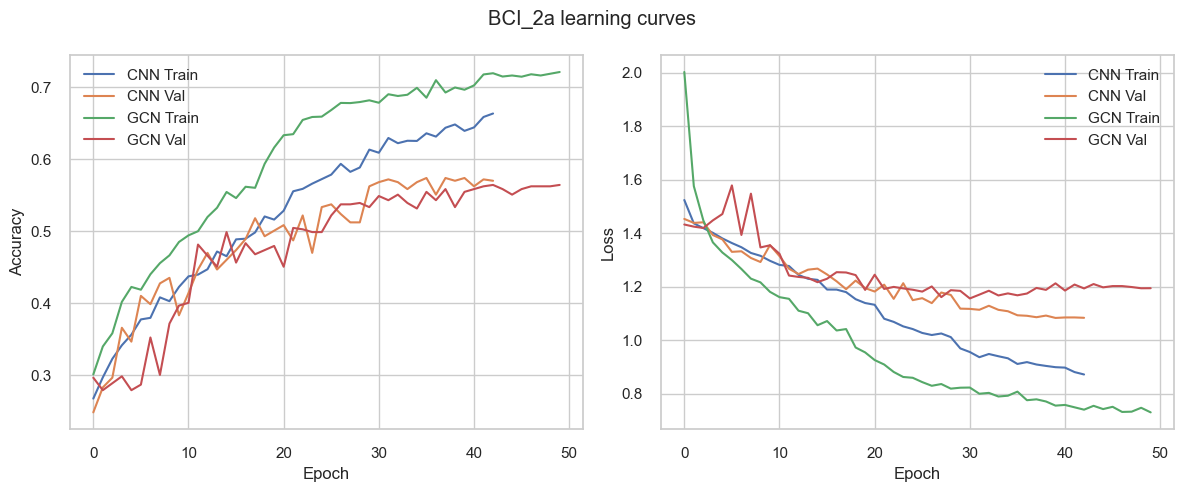

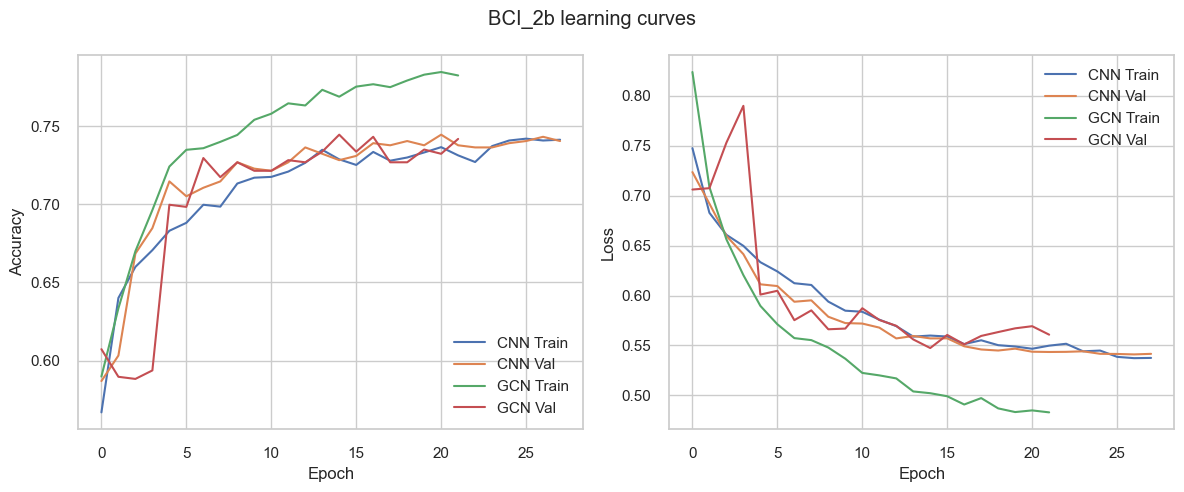

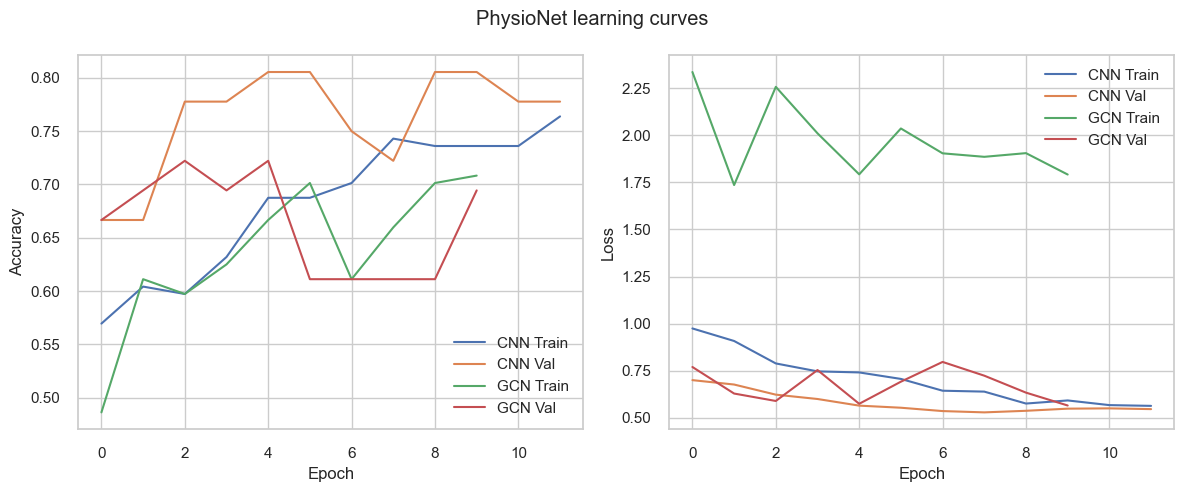

In [ ]:
if not model_registry:
    print('No training histories found. Run training first.')
else:
    for name, artifacts in model_registry.items():
        plt.figure(figsize=(12, 5))
        plt.suptitle(f"{name} learning curves")

        plt.subplot(1, 2, 1)
        plt.plot(artifacts['cnn_history']['accuracy'], label='CNN Train')
        plt.plot(artifacts['cnn_history']['val_accuracy'], label='CNN Val')
        plt.plot(artifacts['gcn_history']['accuracy'], label='GCN Train')
        plt.plot(artifacts['gcn_history']['val_accuracy'], label='GCN Val')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(artifacts['cnn_history']['loss'], label='CNN Train')
        plt.plot(artifacts['cnn_history']['val_loss'], label='CNN Val')
        plt.plot(artifacts['gcn_history']['loss'], label='GCN Train')
        plt.plot(artifacts['gcn_history']['val_loss'], label='GCN Val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()


## Cross-Dataset Comparison
When the  is available, this cell builds a visual summary.


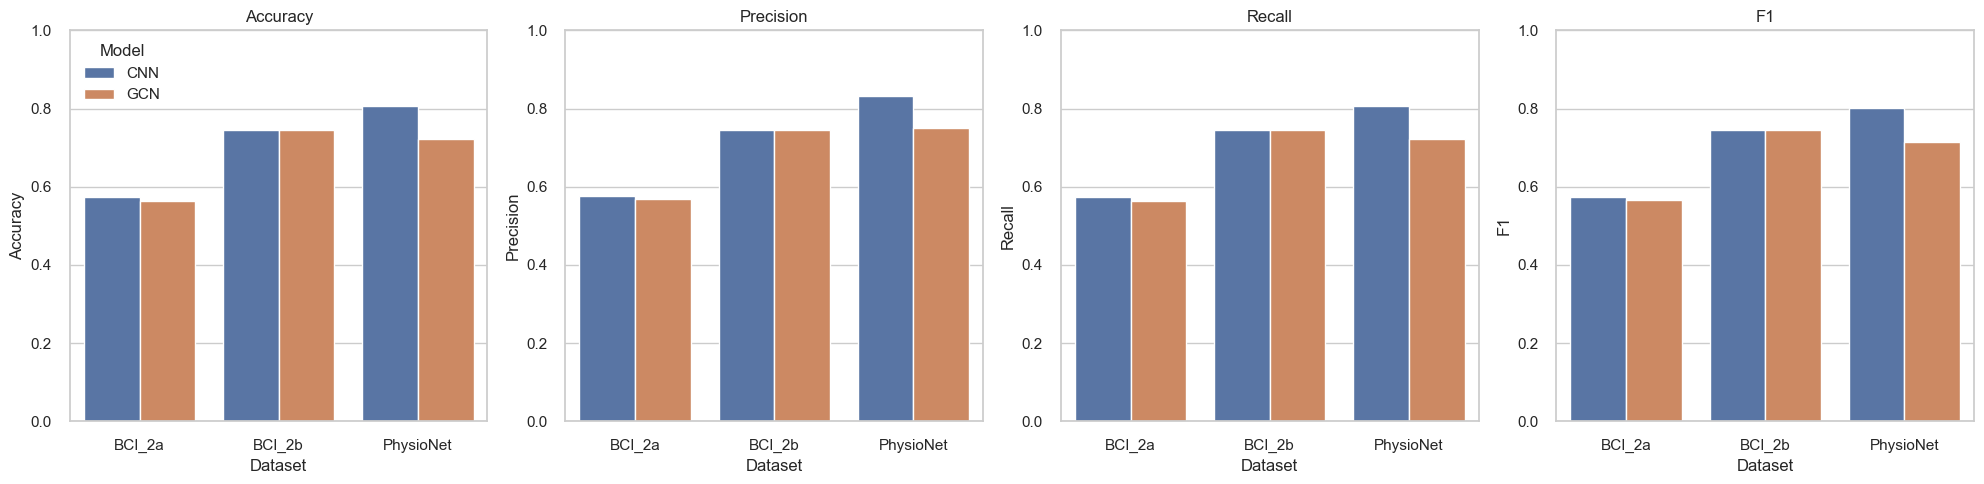

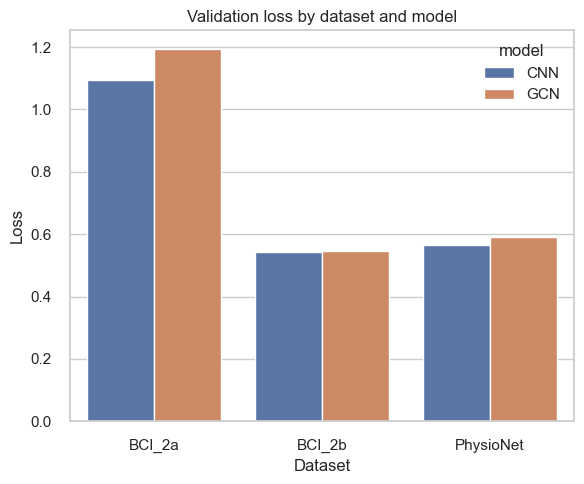

In [ ]:
if 'results_df' not in globals() or results_df.empty:
    print('No results dataframe available. Run training first.')
else:
    metric_names = ['accuracy', 'precision', 'recall', 'f1']
    fig, axes = plt.subplots(1, len(metric_names), figsize=(5 * len(metric_names), 5), sharey=False)
    if len(metric_names) == 1:
        axes = [axes]
    for ax, metric in zip(axes, metric_names):
        sns.barplot(data=results_df, x='dataset', y=metric, hue='model', ax=ax)
        ax.set_title(metric.title())
        ax.set_ylim(0, 1)
        ax.set_xlabel('Dataset')
        ax.set_ylabel(metric.title())
        if ax is not axes[0]:
            ax.legend_.remove()
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, title='Model')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.barplot(data=results_df, x='dataset', y='loss', hue='model')
    plt.title('Validation loss by dataset and model')
    plt.xlabel('Dataset')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()


In [ ]:
if not reports_registry:
    print('No classification reports available. Run training first.')
else:
    for dataset_name, model_reports in reports_registry.items():
        print(f"=== {dataset_name} ===")
        for model_name, report_dict in model_reports.items():
            print(f"=== {model_name} ===")
            normalized = {}
            for label, stats in report_dict.items():
                if isinstance(stats, dict):
                    normalized[label] = stats
                else:
                    normalized[label] = {'score': stats}
            report_df = pd.DataFrame.from_dict(normalized, orient='index')
            columns_to_show = [col for col in ['precision', 'recall', 'f1-score', 'support', 'score'] if col in report_df.columns]
            display(report_df[columns_to_show])


=== BCI_2a ===
=== CNN ===


,precision,recall,f1-score,support,score
foot,0.496503,0.546154,0.520147,130.0,NaN
left_hand,0.601626,0.573643,0.587302,129.0,NaN
right_hand,0.602837,0.653846,0.627306,130.0,NaN
tongue,0.607143,0.523077,0.561983,130.0,NaN
macro avg,0.577027,0.574180,0.574184,519.0,NaN
weighted avg,0.576980,0.574181,0.574159,519.0,NaN
accuracy,NaN,NaN,NaN,NaN,0.574181


=== GCN ===


,precision,recall,f1-score,support,score
foot,0.500000,0.523077,0.511278,130.0,NaN
left_hand,0.541667,0.604651,0.571429,129.0,NaN
right_hand,0.641667,0.592308,0.616000,130.0,NaN
tongue,0.588235,0.538462,0.562249,130.0,NaN
macro avg,0.567892,0.564624,0.565239,519.0,NaN
weighted avg,0.567943,0.564547,0.565227,519.0,NaN
accuracy,NaN,NaN,NaN,NaN,0.564547


=== BCI_2b ===
=== CNN ===


,precision,recall,f1-score,support,score
left_hand,0.744565,0.744565,0.744565,368.0,NaN
right_hand,0.744565,0.744565,0.744565,368.0,NaN
macro avg,0.744565,0.744565,0.744565,736.0,NaN
weighted avg,0.744565,0.744565,0.744565,736.0,NaN
accuracy,NaN,NaN,NaN,NaN,0.744565


=== GCN ===


,precision,recall,f1-score,support,score
left_hand,0.736842,0.760870,0.748663,368.0,NaN
right_hand,0.752809,0.728261,0.740331,368.0,NaN
macro avg,0.744826,0.744565,0.744497,736.0,NaN
weighted avg,0.744826,0.744565,0.744497,736.0,NaN
accuracy,NaN,NaN,NaN,NaN,0.744565


=== PhysioNet ===
=== CNN ===


,precision,recall,f1-score,support,score
left_fist,0.739130,0.944444,0.829268,18.0,NaN
right_fist,0.923077,0.666667,0.774194,18.0,NaN
macro avg,0.831104,0.805556,0.801731,36.0,NaN
weighted avg,0.831104,0.805556,0.801731,36.0,NaN
accuracy,NaN,NaN,NaN,NaN,0.805556


=== GCN ===


,precision,recall,f1-score,support,score
left_fist,0.833333,0.555556,0.666667,18.0,NaN
right_fist,0.666667,0.888889,0.761905,18.0,NaN
macro avg,0.750000,0.722222,0.714286,36.0,NaN
weighted avg,0.750000,0.722222,0.714286,36.0,NaN
accuracy,NaN,NaN,NaN,NaN,0.722222


## Next Steps
- Expand the subject/run lists once the pipeline runs smoothly on this subset.
- Experiment with more expressive graph constructions (distance-based, mutual information).
- Evaluate ES/AS channel selection on top of the trained models to identify minimal electrode sets.
- Consider cross-subject generalisation by holding out entire subjects for validation.
